## 1. Import libraries

In [23]:
import numpy as np
import pandas as pd
pd.set_option("display.max_columns",None)

import sklearn
sklearn.set_config(transform_output= "pandas") 

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
	OneHotEncoder,
	OrdinalEncoder,
	StandardScaler,
	MinMaxScaler,
	PowerTransformer,
	FunctionTransformer,
    KBinsDiscretizer
)
from category_encoders import TargetEncoder


import seaborn as sns 
from feature_engine.outliers import Winsorizer
from feature_engine.datetime import DatetimeFeatures
from feature_engine.selection import SelectBySingleFeaturePerformance
from feature_engine.encoding import (
	RareLabelEncoder,
	MeanEncoder,
	CountFrequencyEncoder
)

import matplotlib.pyplot as plt

import os

import warnings
warnings.filterwarnings("ignore")

## 2. Read the dataset

In [74]:
def get_data(name, base_dir=None):
    # If base_dir is not provided, use the current working directory
    if base_dir is None:
        base_dir = os.getcwd()
    
    # Construct the path to the Data directory
    data_dir = os.path.join(base_dir, '..', 'Data')
    
    # Construct the full file path
    file_name = f"{name}.csv"
    file_path = os.path.join(data_dir, file_name)
    
    # Check if the file exists
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"The file {file_name} does not exist in the specified path.")
    
    # Read and return the CSV file
    return pd.read_csv(file_path)

In [75]:
train = get_data('eda_data')
train.shape

(199588, 30)

In [76]:
train.head()

,serviceCharge,picturecount,pricetrend,telekomUploadSpeed,totalRent,baseRent,livingSpace,noRooms,residents,zip_area_sq_km,stateName,heatingType,telekomTvOffer,newlyConst,balcony,firingTypes,hasKitchen,cellar,condition,interiorQual,petsAllowed,lift,typeOfFlat,geo_plz,garden,date,cityCode,cityName,yearConstructed_category,floor_category
0,245.00,6,4.62,10,840.0,595.0,86.00,4,21539,7.401962,Nordrhein_Westfalen,central_heating,ONE_YEAR_FREE,False,False,oil,False,True,well_kept,normal,unknown,False,ground_floor,44269,True,May 2019,44,Dortmund,1952-1973,floor_0_3
1,255.00,8,2.72,2,1300.0,965.0,83.80,3,14821,3.298022,Sachsen,floor_heating,ONE_YEAR_FREE,True,True,gas,False,True,first_time_use,sophisticated,unknown,True,apartment,1097,False,Oct 2019,1,Dresden,1997-2030,floor_0_3
2,58.15,9,1.53,40,655.0,343.0,58.15,3,39861,48.291826,Sachsen,district_heating,ONE_YEAR_FREE,False,True,district_heating,False,False,unknown,unknown,unknown,False,other,9599,False,May 2019,9,Chemnitz,1952-1973,floor_0_3
3,138.00,19,2.46,40,903.0,765.0,84.97,3,12077,4.044656,Bremen,self_contained_central_heating,unknown,False,True,gas,False,False,refurbished,unknown,unknown,False,apartment,28213,False,Feb 2020,28,Bremen,1881-1952,floor_0_3
4,142.00,5,4.48,2,655.0,315.2,53.43,2,1302,24.861634,Schleswig_Holstein,gas_heating,unknown,False,True,gas,True,False,well_kept,unknown,no,False,apartment,24891,False,Feb 2020,24,Kiel,1997-2030,floor_0_3


In [77]:
print(f'No of categorical columns: {train.select_dtypes(include='object').shape[1]}')
print(f'No of numerical columns: {train.select_dtypes(exclude ='object').shape[1]}')

No of categorical columns: 12
No of numerical columns: 18


## 3. Creating New Features

In [78]:
# creating new column total rent per square meters
train['baseRentPerSquareMeter']= train['baseRent']/train['livingSpace']
train['service_charge_ratio'] = train['serviceCharge'] / train['baseRent']

In [79]:
# 4. Room efficiency
train['space_per_room'] = train['livingSpace'] / train['noRooms']

In [80]:
# make new column called address
train['address'] = train['geo_plz'].astype(str) + ' ' + train['cityName']  + ' ' + train['stateName'] 

In [59]:
print(f'No of categorical columns: {train.select_dtypes(include='object').shape[1]}')
print(f'No of numerical columns: {train.select_dtypes(exclude ='object').shape[1]}')

No of categorical columns: 13
No of numerical columns: 21


In [60]:
# changing datatypes of the column
columns_to_convert = ['telekomUploadSpeed', 'noRooms', 'geo_plz', 'picturecount', 
                      'newlyConst', 'balcony', 'hasKitchen', 'cellar', 'lift', 
                      'garden', 'cityCode']

train[columns_to_convert] = train[columns_to_convert].astype('int').astype('object')

In [64]:
print(f'No of categorical columns: {train.select_dtypes(include='object').shape[1]}')
print(f'No of numerical columns: {train.select_dtypes(include ='number').shape[1]}')
                               

No of categorical columns: 24
No of numerical columns: 10


## 4. Transformation operations

### Pairplot Numerical features

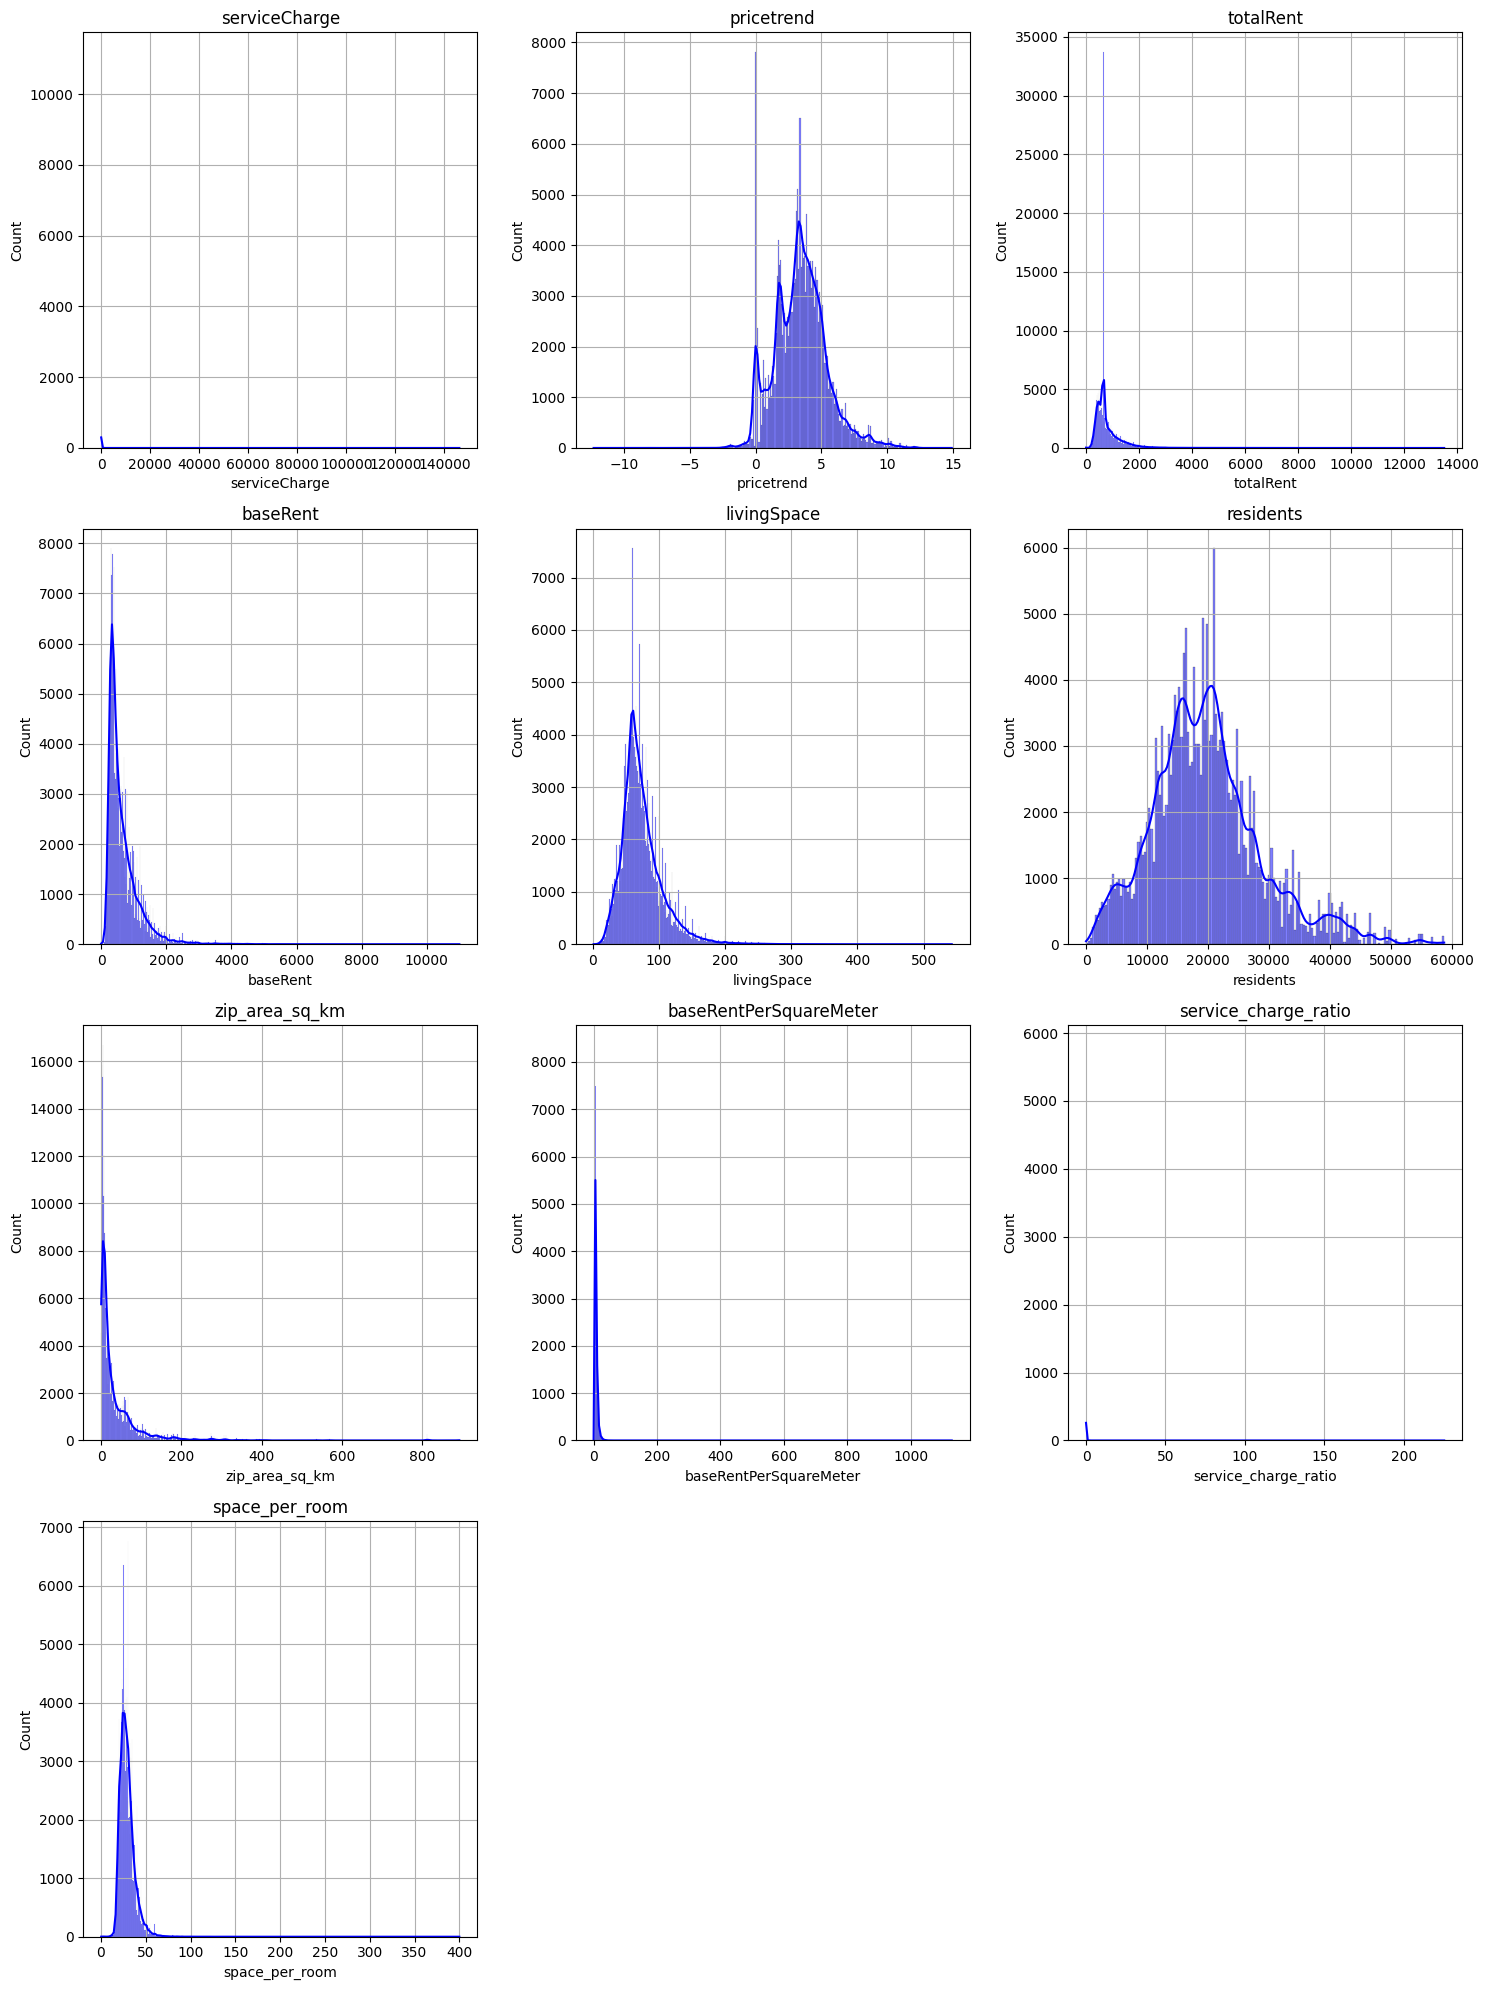

In [62]:
num_cols = train.select_dtypes(exclude='object').columns

n_cols = 3
n_rows = int(np.ceil(len(num_cols) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

# Flatten the axes
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.histplot(data=train, x=col, ax=axes[i], kde=True, color='blue')
    axes[i].set_title(col, fontsize=12)
    axes[i].grid(True)

# Remove unused subplots
for j in range(len(num_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Pairplot after log transformations

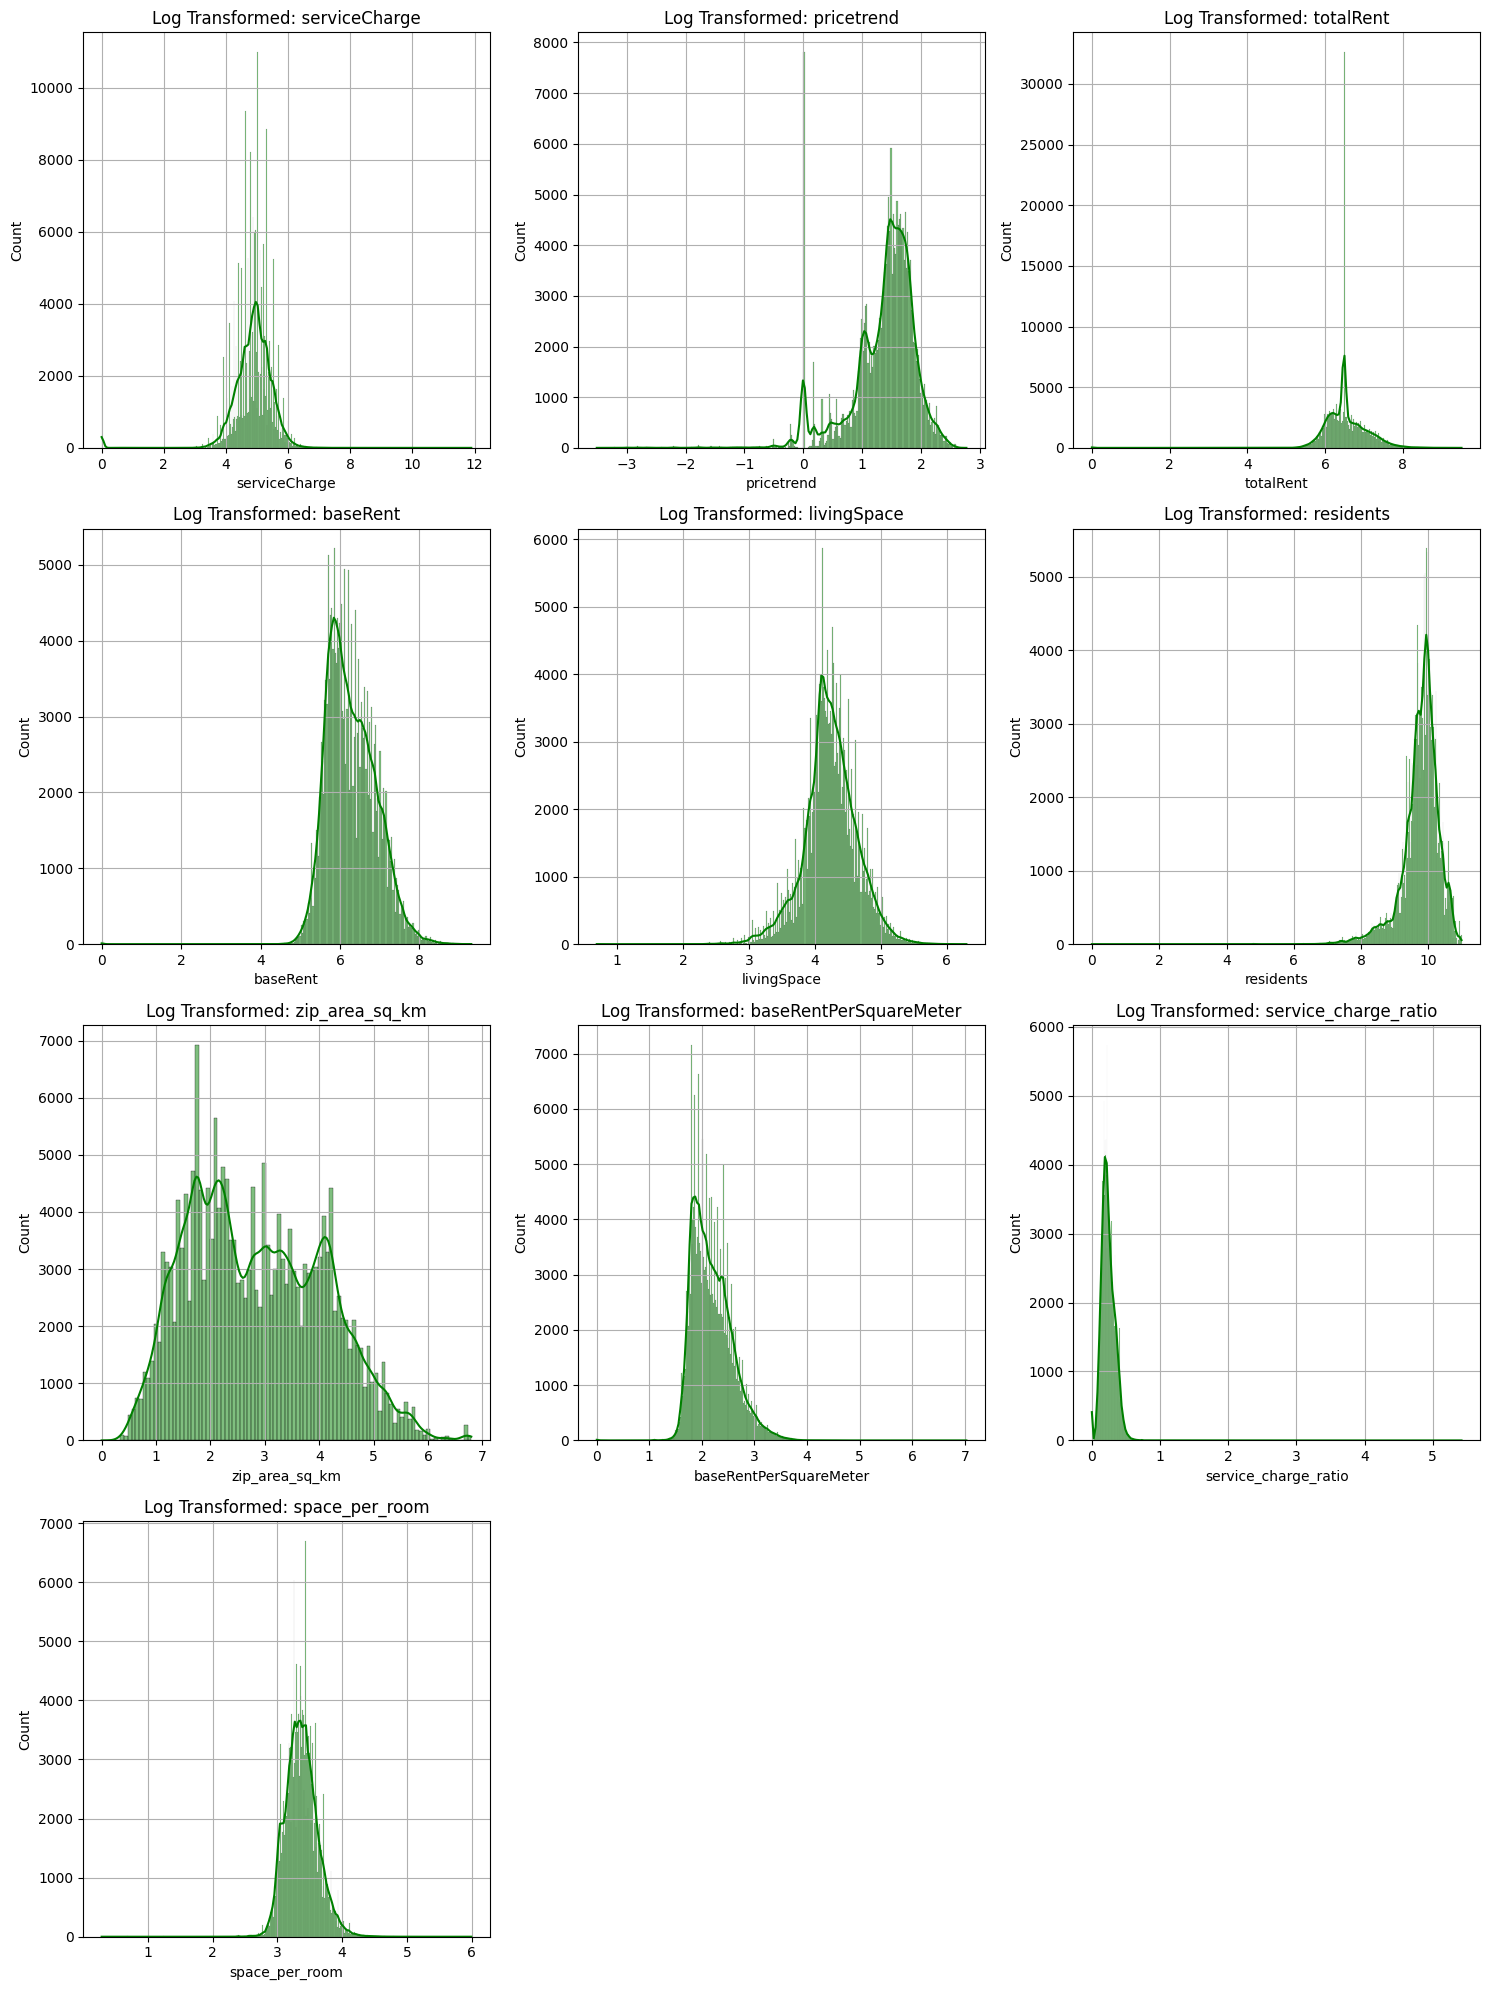

In [65]:

num_cols = train.select_dtypes(exclude='object').columns

# Apply log transformation using np.log1p (log(1 + x))
train_log = train.copy()
for col in num_cols:
    train_log[col] = np.log1p(train[col])

# Plot the transformed data
n_cols = 3
n_rows = int(np.ceil(len(num_cols) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.histplot(data=train_log, x=col, ax=axes[i], kde=True, color='green')
    axes[i].set_title(f'Log Transformed: {col}', fontsize=12)
    axes[i].grid(True)

# Remove unused subplots
for j in range(len(num_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### 3.1 Transformations on Numerical columns

In [66]:
X = train.drop(columns = ['totalRent'],axis= 1)
y = train['totalRent']

#### YeoJohnson and MinMax Scaling


In [67]:
num_cols = X.select_dtypes(include='number').columns

# Check for negative or zero values and handle them (for Box-Cox)
X[num_cols] = X[num_cols].applymap(lambda x: x + 1 if x <= 0 else x)
X[num_cols] = X[num_cols].applymap(lambda x: np.nan if x == np.inf or x == -np.inf else x)


# Create transformers
yeo_johnson_transformer = PowerTransformer(method='yeo-johnson', standardize=True)
min_max_transformer = MinMaxScaler()
log_transformer = FunctionTransformer(np.log1p, validate=True)

# Define the numerical preprocessing pipeline
numerical_pipeline = Pipeline(steps=[
    ('yeo_johnson', PowerTransformer(method='yeo-johnson', standardize=True)),  # Step 1: Yeo-Johnson
    ('min_max_scaler', MinMaxScaler())  # Step 2: Min-Max Scaling
])

# Create a pipeline with all transformations
numerical_preprocessing_pipeline = ColumnTransformer(
    transformers =[
        ('num_pipeline', numerical_pipeline, num_cols)  # Apply to numerical columns
    ],
    remainder='drop'
)


preprocessed_num_data = numerical_preprocessing_pipeline.fit_transform(X,y)
display(pd.DataFrame(preprocessed_num_data).head())  # Inspect the output
print(pd.DataFrame(preprocessed_num_data).shape)

,num_pipeline__serviceCharge,num_pipeline__pricetrend,num_pipeline__baseRent,num_pipeline__livingSpace,num_pipeline__residents,num_pipeline__zip_area_sq_km,num_pipeline__baseRentPerSquareMeter,num_pipeline__service_charge_ratio,num_pipeline__space_per_room
0,0.093818,0.841059,0.739537,0.608475,0.553207,0.412911,0.761024,0.672659,0.657155
1,0.095355,0.802500,0.787266,0.603505,0.443616,0.294981,0.827270,0.532027,0.697159
2,0.050773,0.774746,0.682779,0.534954,0.795387,0.678609,0.736670,0.397791,0.640781
3,0.073984,0.796737,0.764583,0.606162,0.393051,0.324112,0.797415,0.415548,0.699223
4,0.074880,0.838392,0.673839,0.519483,0.104444,0.588819,0.736690,0.700137,0.690482


(199588, 9)


In [68]:
numerical_preprocessing_pipeline

ColumnTransformer(transformers=[('num_pipeline',
                                 Pipeline(steps=[('yeo_johnson',
                                                  PowerTransformer()),
                                                 ('min_max_scaler',
                                                  MinMaxScaler())]),
                                 Index(['serviceCharge', 'pricetrend', 'baseRent', 'livingSpace', 'residents',
       'zip_area_sq_km', 'baseRentPerSquareMeter', 'service_charge_ratio',
       'space_per_room'],
      dtype='object'))])

### 3.2 Feature Engineering Categorical Columns

In [69]:
(
    train
    .select_dtypes(include=['object','bool'])
    .head()
)

,picturecount,telekomUploadSpeed,noRooms,stateName,heatingType,telekomTvOffer,newlyConst,balcony,firingTypes,hasKitchen,cellar,condition,interiorQual,petsAllowed,lift,typeOfFlat,geo_plz,garden,date,cityCode,cityName,yearConstructed_category,floor_category,address
0,6,10,4,Nordrhein_Westfalen,central_heating,ONE_YEAR_FREE,0,0,oil,0,1,well_kept,normal,unknown,0,ground_floor,44269,1,May 2019,44,Dortmund,1952-1973,floor_0_3,44269 Dortmund Nordrhein_Westfalen
1,8,2,3,Sachsen,floor_heating,ONE_YEAR_FREE,1,1,gas,0,1,first_time_use,sophisticated,unknown,1,apartment,1097,0,Oct 2019,1,Dresden,1997-2030,floor_0_3,1097 Dresden Sachsen
2,9,40,3,Sachsen,district_heating,ONE_YEAR_FREE,0,1,district_heating,0,0,unknown,unknown,unknown,0,other,9599,0,May 2019,9,Chemnitz,1952-1973,floor_0_3,9599 Chemnitz Sachsen
3,19,40,3,Bremen,self_contained_central_heating,unknown,0,1,gas,0,0,refurbished,unknown,unknown,0,apartment,28213,0,Feb 2020,28,Bremen,1881-1952,floor_0_3,28213 Bremen Bremen
4,5,2,2,Schleswig_Holstein,gas_heating,unknown,0,1,gas,1,0,well_kept,unknown,no,0,apartment,24891,0,Feb 2020,24,Kiel,1997-2030,floor_0_3,24891 Kiel Schleswig_Holstein


In [70]:
print(train.select_dtypes(include=['object','bool']).shape)

(199588, 24)


In [71]:
(
    train
    .select_dtypes(include=['object','bool'])
    .nunique()
    .sort_values(ascending=False)
)

address                     6558
geo_plz                     6537
firingTypes                  128
cityCode                      95
picturecount                  92
cityName                      88
stateName                     16
noRooms                       14
heatingType                   13
condition                     11
typeOfFlat                    10
telekomUploadSpeed             6
interiorQual                   5
floor_category                 5
date                           4
yearConstructed_category       4
petsAllowed                    4
telekomTvOffer                 3
garden                         2
newlyConst                     2
cellar                         2
hasKitchen                     2
balcony                        2
lift                           2
dtype: int64

### Encoding Strategies
- **Binary**: Label Encoding or One-Hot Encoding
- **Low Cardinality**: One-Hot Encoding
- **Medium Cardinality**: One-Hot Encoding or Target Encoding
- **High Cardinality**: Target Encoding, Frequency Encoding, or Embedding

In [73]:
X.columns

Index(['serviceCharge', 'picturecount', 'pricetrend', 'telekomUploadSpeed',
       'baseRent', 'livingSpace', 'noRooms', 'residents', 'zip_area_sq_km',
       'stateName', 'heatingType', 'telekomTvOffer', 'newlyConst', 'balcony',
       'firingTypes', 'hasKitchen', 'cellar', 'condition', 'interiorQual',
       'petsAllowed', 'lift', 'typeOfFlat', 'geo_plz', 'garden', 'date',
       'cityCode', 'cityName', 'yearConstructed_category', 'floor_category',
       'baseRentPerSquareMeter', 'service_charge_ratio', 'space_per_room',
       'address'],
      dtype='object')

In [81]:

# Define feature groups
binary_features = ['newlyConst', 'balcony', 'hasKitchen', 'cellar', 'lift', 'garden']
low_card_features = ['stateName', 'telekomTvOffer', 'petsAllowed', 'typeOfFlat']
med_card_features = ['heatingType', 'condition', 'interiorQual']
high_card_features = ['geo_plz', 'cityName', 'firingTypes', 'address']
numeric_binned = ['picturecount', 'noRooms']
ordinal_features = ['yearConstructed_category', 'floor_category']

In [82]:
# create preprocessing steps
binary_transformer = 'passthrough'
low_card_transformer = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
med_card_transformer = TargetEncoder()
high_card_transformer = TargetEncoder()
numeric_binned_transformer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
ordinal_transformer = OrdinalEncoder()

In [83]:
# creating categorical preprocessing pipeline
categorical_preprocessing_pipeline = ColumnTransformer(
    transformers=[
        ('binary', 'passthrough', binary_features),
        ('low_card', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), low_card_features),
        ('med_card', TargetEncoder(), med_card_features),
        ('high_card', TargetEncoder(), high_card_features),
        ('numeric_binned', KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform'), numeric_binned),
        ('ordinal', OrdinalEncoder(), ordinal_features)
    ],
    remainder='drop'
)


In [84]:
categorical_preprocessing_pipeline

ColumnTransformer(transformers=[('binary', 'passthrough',
                                 ['newlyConst', 'balcony', 'hasKitchen',
                                  'cellar', 'lift', 'garden']),
                                ('low_card',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 ['stateName', 'telekomTvOffer', 'petsAllowed',
                                  'typeOfFlat']),
                                ('med_card', TargetEncoder(),
                                 ['heatingType', 'condition', 'interiorQual']),
                                ('high_card', TargetEncoder(),
                                 ['geo_plz', 'cityName', 'firingTypes',
                                  'address']),
                                ('numeric_binned',
                                 KBinsDiscretizer(encode='ordinal',
                                                  strategy='uniform'),
                                 ['picturecount', 'noRooms']),
                                ('ordinal', OrdinalEncoder(),
                                 ['yearConstructed_category',
                                  'floor_category'])])

In [85]:
print(categorical_preprocessing_pipeline)

ColumnTransformer(transformers=[('binary', 'passthrough',
                                 ['newlyConst', 'balcony', 'hasKitchen',
                                  'cellar', 'lift', 'garden']),
                                ('low_card',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 ['stateName', 'telekomTvOffer', 'petsAllowed',
                                  'typeOfFlat']),
                                ('med_card', TargetEncoder(),
                                 ['heatingType', 'condition', 'interiorQual']),
                                ('high_card', TargetEncoder(),
                                 ['geo_plz', 'cityName', 'firingTypes',
                                  'address']),
                                ('numeric_binned',
                                 KBinsDiscretizer(encode='ordinal',
                                              

In [86]:
preprocessed_cat_data = categorical_preprocessing_pipeline.fit_transform(X,y)
preprocessed_cat_df = pd.DataFrame(preprocessed_cat_data)
display(preprocessed_cat_df.head())
print(preprocessed_cat_df.shape)

,binary__newlyConst,binary__balcony,binary__hasKitchen,binary__cellar,binary__lift,binary__garden,low_card__stateName_Baden_Württemberg,low_card__stateName_Bayern,low_card__stateName_Berlin,low_card__stateName_Brandenburg,low_card__stateName_Bremen,low_card__stateName_Hamburg,low_card__stateName_Hessen,low_card__stateName_Mecklenburg_Vorpommern,low_card__stateName_Niedersachsen,low_card__stateName_Nordrhein_Westfalen,low_card__stateName_Rheinland_Pfalz,low_card__stateName_Saarland,low_card__stateName_Sachsen,low_card__stateName_Sachsen_Anhalt,low_card__stateName_Schleswig_Holstein,low_card__stateName_Thüringen,low_card__telekomTvOffer_ONE_YEAR_FREE,low_card__telekomTvOffer_ON_DEMAND,low_card__telekomTvOffer_unknown,low_card__petsAllowed_negotiable,low_card__petsAllowed_no,low_card__petsAllowed_unknown,low_card__petsAllowed_yes,low_card__typeOfFlat_apartment,low_card__typeOfFlat_ground_floor,low_card__typeOfFlat_half_basement,low_card__typeOfFlat_loft,low_card__typeOfFlat_maisonette,low_card__typeOfFlat_other,low_card__typeOfFlat_penthouse,low_card__typeOfFlat_raised_ground_floor,low_card__typeOfFlat_roof_storey,low_card__typeOfFlat_terraced_flat,med_card__heatingType,med_card__condition,med_card__interiorQual,high_card__geo_plz,high_card__cityName,high_card__firingTypes,high_card__address,numeric_binned__picturecount,numeric_binned__noRooms,ordinal__yearConstructed_category,ordinal__floor_category
0,0,0,0,1,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,747.076624,703.509425,619.951336,946.622478,687.787318,815.145102,946.622478,0.0,1.0,1.0,0.0
1,1,1,0,1,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1208.385582,1208.210683,1048.276586,812.293151,654.820533,781.698837,812.293151,0.0,0.0,3.0,0.0
2,0,1,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,767.005579,709.370499,718.525449,585.580047,482.951137,805.314715,585.580047,0.0,0.0,1.0,0.0
3,0,1,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,719.036013,636.490649,718.525449,974.782232,846.164639,781.698837,974.782232,0.0,0.0,0.0,0.0
4,0,1,1,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,806.037467,703.509425,718.525449,792.184408,767.154854,781.698837,792.184408,0.0,0.0,3.0,0.0


(199588, 50)


In [87]:
# property type
luxury_types = ['low_card__typeOfFlat_penthouse', 
                'low_card__typeOfFlat_loft',
                'low_card__typeOfFlat_maisonette']
preprocessed_cat_df['is_luxury_property'] = preprocessed_cat_df[luxury_types].any(axis=1).astype(int)


In [88]:
(
    preprocessed_cat_df
    .nunique()
    .sort_values(ascending=False)
)

high_card__address                            5496
high_card__geo_plz                            5487
high_card__firingTypes                         113
high_card__cityName                             88
med_card__heatingType                           13
med_card__condition                             11
numeric_binned__picturecount                     5
numeric_binned__noRooms                          5
ordinal__floor_category                          5
med_card__interiorQual                           5
ordinal__yearConstructed_category                4
low_card__typeOfFlat_maisonette                  2
low_card__petsAllowed_yes                        2
low_card__typeOfFlat_apartment                   2
low_card__typeOfFlat_ground_floor                2
low_card__typeOfFlat_half_basement               2
low_card__typeOfFlat_loft                        2
binary__newlyConst                               2
low_card__typeOfFlat_other                       2
low_card__typeOfFlat_penthouse 

## 4. Combining both pipeline

In [89]:
preprocessing_pipeline = ColumnTransformer(
    transformers=[
        ('numerical', numerical_preprocessing_pipeline, list(X.select_dtypes(include=['number']).columns)),
        ('categorical', categorical_preprocessing_pipeline,list(X.select_dtypes(include=['object', 'bool']).columns) )
    ],
    remainder='drop'
)

In [90]:
preprocessing_pipeline

ColumnTransformer(transformers=[('numerical',
                                 ColumnTransformer(transformers=[('num_pipeline',
                                                                  Pipeline(steps=[('yeo_johnson',
                                                                                   PowerTransformer()),
                                                                                  ('min_max_scaler',
                                                                                   MinMaxScaler())]),
                                                                  Index(['serviceCharge', 'pricetrend', 'baseRent', 'livingSpace', 'residents',
       'zip_area_sq_km', 'baseRentPerSquareMeter', 'service_charge_ratio',
       'space_per_room'],
      dtype='object'...
                                                                  ['yearConstructed_category',
                                                                   'floor_category'])]),
                                 ['picturecount', 'telekomUploadSpeed',
                                  'noRooms', 'stateName', 'heatingType',
                                  'telekomTvOffer', 'newlyConst', 'balcony',
                                  'firingTypes', 'hasKitchen', 'cellar',
                                  'condition', 'interiorQual', 'petsAllowed',
                                  'lift', 'typeOfFlat', 'geo_plz', 'garden',
                                  'date', 'cityCode', 'cityName',
                                  'yearConstructed_category', 'floor_category',
                                  'address'])])

In [91]:
print(preprocessing_pipeline)

ColumnTransformer(transformers=[('numerical',
                                 ColumnTransformer(transformers=[('num_pipeline',
                                                                  Pipeline(steps=[('yeo_johnson',
                                                                                   PowerTransformer()),
                                                                                  ('min_max_scaler',
                                                                                   MinMaxScaler())]),
                                                                  Index(['serviceCharge', 'pricetrend', 'baseRent', 'livingSpace', 'residents',
       'zip_area_sq_km', 'baseRentPerSquareMeter', 'service_charge_ratio',
       'space_per_room'],
      dtype='object'...
                                                                  ['yearConstructed_category',
                                                                   'floor_category'])]),
              

In [92]:

# Apply transformations
preprocessed_data = preprocessing_pipeline.fit_transform(X,y)

# Get feature names
# This part might need adjustment based on your specific dataset
feature_names = list(preprocessing_pipeline.get_feature_names_out())
print(len(feature_names))


59


In [93]:
# Create DataFrame
preprocessed_data_df = pd.DataFrame(
    preprocessed_data, 
    columns=feature_names, 
    index=X.index
)

# Display the first few rows
display(preprocessed_data_df.head())
print(preprocessed_data_df.shape)

,numerical__num_pipeline__serviceCharge,numerical__num_pipeline__pricetrend,numerical__num_pipeline__baseRent,numerical__num_pipeline__livingSpace,numerical__num_pipeline__residents,numerical__num_pipeline__zip_area_sq_km,numerical__num_pipeline__baseRentPerSquareMeter,numerical__num_pipeline__service_charge_ratio,numerical__num_pipeline__space_per_room,categorical__binary__newlyConst,categorical__binary__balcony,categorical__binary__hasKitchen,categorical__binary__cellar,categorical__binary__lift,categorical__binary__garden,categorical__low_card__stateName_Baden_Württemberg,categorical__low_card__stateName_Bayern,categorical__low_card__stateName_Berlin,categorical__low_card__stateName_Brandenburg,categorical__low_card__stateName_Bremen,categorical__low_card__stateName_Hamburg,categorical__low_card__stateName_Hessen,categorical__low_card__stateName_Mecklenburg_Vorpommern,categorical__low_card__stateName_Niedersachsen,categorical__low_card__stateName_Nordrhein_Westfalen,categorical__low_card__stateName_Rheinland_Pfalz,categorical__low_card__stateName_Saarland,categorical__low_card__stateName_Sachsen,categorical__low_card__stateName_Sachsen_Anhalt,categorical__low_card__stateName_Schleswig_Holstein,categorical__low_card__stateName_Thüringen,categorical__low_card__telekomTvOffer_ONE_YEAR_FREE,categorical__low_card__telekomTvOffer_ON_DEMAND,categorical__low_card__telekomTvOffer_unknown,categorical__low_card__petsAllowed_negotiable,categorical__low_card__petsAllowed_no,categorical__low_card__petsAllowed_unknown,categorical__low_card__petsAllowed_yes,categorical__low_card__typeOfFlat_apartment,categorical__low_card__typeOfFlat_ground_floor,categorical__low_card__typeOfFlat_half_basement,categorical__low_card__typeOfFlat_loft,categorical__low_card__typeOfFlat_maisonette,categorical__low_card__typeOfFlat_other,categorical__low_card__typeOfFlat_penthouse,categorical__low_card__typeOfFlat_raised_ground_floor,categorical__low_card__typeOfFlat_roof_storey,categorical__low_card__typeOfFlat_terraced_flat,categorical__med_card__heatingType,categorical__med_card__condition,categorical__med_card__interiorQual,categorical__high_card__geo_plz,categorical__high_card__cityName,categorical__high_card__firingTypes,categorical__high_card__address,categorical__numeric_binned__picturecount,categorical__numeric_binned__noRooms,categorical__ordinal__yearConstructed_category,categorical__ordinal__floor_category
0,0.093818,0.841059,0.739537,0.608475,0.553207,0.412911,0.761024,0.672659,0.657155,0,0,0,1,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,747.076624,703.509425,619.951336,946.622478,687.787318,815.145102,946.622478,0.0,1.0,1.0,0.0
1,0.095355,0.802500,0.787266,0.603505,0.443616,0.294981,0.827270,0.532027,0.697159,1,1,0,1,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1208.385582,1208.210683,1048.276586,812.293151,654.820533,781.698837,812.293151,0.0,0.0,3.0,0.0
2,0.050773,0.774746,0.682779,0.534954,0.795387,0.678609,0.736670,0.397791,0.640781,0,1,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,767.005579,709.370499,718.525449,585.580047,482.951137,805.314715,585.580047,0.0,0.0,1.0,0.0
3,0.073984,0.796737,0.764583,0.606162,0.393051,0.324112,0.797415,0.415548,0.699223,0,1,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,719.036013,636.490649,718.525449,974.782232,846.164639,781.698837,974.782232,0.0,0.0,0.0,0.0
4,0.074880,0.838392,0.673839,0.519483,0.104444,0.588819,0.736690,0.700137,0.690482,0,1,1,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,806.037467,703.509425,718.525449,792.184408,767.154854,781.69883

(199588, 59)


In [94]:
(
    preprocessed_data_df
    .select_dtypes(include=['object','bool'])
    .nunique()
    .sort_values(ascending=False)
)

categorical__binary__newlyConst    2
categorical__binary__balcony       2
categorical__binary__hasKitchen    2
categorical__binary__cellar        2
categorical__binary__lift          2
categorical__binary__garden        2
dtype: int64

In [95]:
preprocessed_data_df = pd.concat([preprocessed_data_df,train['totalRent']], axis=1)
print(preprocessed_data_df.shape)

(199588, 60)


In [96]:
def export_dataframe(dataframe, file_name):
    # defining base dir
    base_dir = os.getcwd()
    
    # Construct the path to the Data directory
    data_dir = os.path.join(base_dir, '..', 'Data')

    # Ensure the directory exists
    os.makedirs(data_dir, exist_ok=True)
    
    # Create the full file path
    file_path = os.path.join(data_dir, file_name)
    
    # Export the dataframe to CSV
    dataframe.to_csv(file_path, index=False)
    
    print(f"DataFrame exported to: {file_path}")

In [97]:
export_dataframe(preprocessed_data_df, 'preprocessed_data.csv')

DataFrame exported to: /Users/sudhirjoon/Library/Mobile Documents/com~apple~CloudDocs/Uni_Mannheim/Sem2/data_visualisation/Joon_project/Notebooks/../Data/preprocessed_data.csv
